In [1]:
import numpy 
import pandas 
import random 
import time
import matplotlib.pyplot as plt

In [2]:
#We are splitting the data set into two parts, 25% for the test and 75% for the training.

def TrainTestSplit(dataFrame, testSize):
    if isinstance(testSize, float):
        testSize = round(testSize * len(dataFrame))
    indices = dataFrame.index.tolist()
    testIndices = random.sample(population = indices, k = testSize)
    dataFrameTest = dataFrame.loc[testIndices]
    dataFrameTrain = dataFrame.drop(testIndices)
    return dataFrameTrain, dataFrameTest

In [3]:
def CheckPurity(data):
    if len(numpy.unique(data[:, -1])) == 1:
        return True
    else:
        return False

In [4]:
def ClassifyData(data):
    uniqueClasses, uniqueClassesCounts = numpy.unique(data[:, -1], return_counts = True)
    return uniqueClasses[uniqueClassesCounts.argmax()]

In [5]:
#In this section, we are trying to find a way to split tumors into malignant and benign types. 
# Some features are more important and they have a more severe effect on tumor type.

def GetPotentialSplits(data, randomAttributes):
    potentialSplits = {}
    _, columns = data.shape
    columnsIndices = list(range(columns - 1))
    if randomAttributes != None  and len(randomAttributes) <= len(columnsIndices):
        columnsIndices = randomAttributes
    for column in columnsIndices:
        values = data[:, column]
        uniqueValues = numpy.unique(values)
        if len(uniqueValues) == 1:
            potentialSplits[column] = uniqueValues
        else:
            potentialSplits[column] = []
            for i in range(len(uniqueValues)):
                if i != 0:
                    currentValue = uniqueValues[i]
                    previousValue = uniqueValues[i - 1]
                    potentialSplits[column].append((currentValue + previousValue) / 2)
    return potentialSplits

In [6]:
def SplitData(data, splitColumn, splitValue):
    splitColumnValues = data[:, splitColumn]
    return data[splitColumnValues <= splitValue], data[splitColumnValues > splitValue]

In [7]:
#In the next couple of sections, we are calculating the Entropy and Overall Entropy. 
# These are the foundational elements of a decision tree algorithm.

def CalculateEntropy(data):
    _, uniqueClassesCounts = numpy.unique(data[:, -1], return_counts = True)
    probabilities = uniqueClassesCounts / uniqueClassesCounts.sum()
    return sum(probabilities * -numpy.log2(probabilities))

In [8]:
def CalculateOverallEntropy(dataBelow, dataAbove):
    pDataBelow = len(dataBelow) / (len(dataBelow) + len(dataAbove))
    pDataAbove = len(dataAbove) / (len(dataBelow) + len(dataAbove))
    return pDataBelow * CalculateEntropy(dataBelow) + pDataAbove * CalculateEntropy(dataAbove)

In [10]:
# Here we are going to choose the best branches that help us the most to figure out if a tumor is M or B.

def DetermineBestSplit(data, potentialSplits, randomSplits = None):
    overallEntropy = 9999
    bestSplitColumn = 0
    bestSplitValue = 0
    if randomSplits == None:
        for splitColumn in potentialSplits:
            for splitValue in potentialSplits[splitColumn]:
                dataBelow, dataAbove = SplitData(data, splitColumn, splitValue)
                currentOverallEntropy = CalculateOverallEntropy(dataBelow, dataAbove)
                if currentOverallEntropy <= overallEntropy:
                    overallEntropy = currentOverallEntropy
                    bestSplitColumn = splitColumn
                    bestSplitValue = splitValue
    else:
        for i in range(randomSplits):
            randomSplitColumn = random.choice(list(potentialSplits))
            randomSplitValue = random.choice(potentialSplits[randomSplitColumn])
            dataBelow, dataAbove = SplitData(data, randomSplitColumn, randomSplitValue)
            currentOverallEntropy = CalculateOverallEntropy(dataBelow, dataAbove)
            if currentOverallEntropy <= overallEntropy:
                overallEntropy = currentOverallEntropy
                bestSplitColumn = randomSplitColumn
                bestSplitValue = randomSplitValue
    return bestSplitColumn, bestSplitValue

In [11]:
def BuildDecisionTree(dataFrame, currentDepth = 0, minSampleSize = 2, maxDepth = 1000, randomAttributes = None, randomSplits = None):
    if currentDepth == 0:
        global COLUMN_HEADERS
        COLUMN_HEADERS = dataFrame.columns
        data = dataFrame.values
        if randomAttributes != None and randomAttributes <= len(COLUMN_HEADERS) - 1:
            randomAttributes = random.sample(population = list(range(len(COLUMN_HEADERS) - 1)), k = randomAttributes)
        else:
            randomAttributes = None
    else:
        data = dataFrame
    if CheckPurity(data) or len(data) < minSampleSize or currentDepth == maxDepth:
        return ClassifyData(data)
    else:
        currentDepth += 1
        potentialSplits = GetPotentialSplits(data, randomAttributes)
        splitColumn, splitValue = DetermineBestSplit(data, potentialSplits, randomSplits)
        dataBelow, dataAbove = SplitData(data, splitColumn, splitValue)
        if len(dataBelow) == 0 or len(dataAbove) == 0:
            return ClassifyData(data)
        else:
            question = str(COLUMN_HEADERS[splitColumn]) + " <= " + str(splitValue)
            decisionSubTree = {question: []}
            yesAnswer = BuildDecisionTree(dataBelow, currentDepth, minSampleSize, maxDepth, randomAttributes, randomSplits)
            noAnswer = BuildDecisionTree(dataAbove, currentDepth, minSampleSize, maxDepth, randomAttributes, randomSplits)
            if yesAnswer == noAnswer:
                decisionSubTree = yesAnswer
            else:
                decisionSubTree[question].append(yesAnswer)
                decisionSubTree[question].append(noAnswer)
            return decisionSubTree

In [12]:
def ClassifySample(sample, decisionTree):
    if not isinstance(decisionTree, dict):
        return decisionTree
    question = list(decisionTree.keys())[0]
    attribute, value = question.split(" <= ")
    if sample[attribute] <= float(value):
        answer = decisionTree[question][0]
    else:
        answer = decisionTree[question][1]
    return ClassifySample(sample, answer)

In [13]:
def DecisionTreePredictions(dataFrame, decisionTree):
    predictions = dataFrame.apply(ClassifySample, axis = 1, args = (decisionTree,))
    return predictions

In [14]:
def CalculateAccuracy(predictedResults, category):
    resultCorrect = predictedResults == category
    return resultCorrect.mean()

In [15]:
dataFrame = pandas.read_csv("Data.csv")
dataFrame = dataFrame.drop("id", axis = 1)
dataFrame = dataFrame[dataFrame.columns.tolist()[1: ] + dataFrame.columns.tolist()[0: 1]]
dataFrameTrain, dataFrameTest = TrainTestSplit(dataFrame, testSize = 0.25)

print("Decision Tree - Wisconsin Breast Cancer Dataset")

Decision Tree - Wisconsin Breast Cancer Dataset


In [16]:
depths = []
accuracies = []

In [17]:
i = 1
accuracyTrain = 0
while accuracyTrain < 100:
    startTime = time.time()
    decisionTree = BuildDecisionTree(dataFrameTrain, maxDepth = i)
    buildingTime = time.time() - startTime
    decisionTreeTestResults = DecisionTreePredictions(dataFrameTest, decisionTree)
    accuracyTest = CalculateAccuracy(decisionTreeTestResults, dataFrameTest.iloc[:, -1]) * 100
    decisionTreeTrainResults = DecisionTreePredictions(dataFrameTrain, decisionTree)
    accuracyTrain = CalculateAccuracy(decisionTreeTrainResults, dataFrameTrain.iloc[:, -1]) * 100
    print("maxDepth = {}: ".format(i), end = "")
    depths.append(i)
    print("accTest = {0:.2f}%, ".format(accuracyTest), end = "")
    accuracies.append(accuracyTest)
    print("accTrain = {0:.2f}%, ".format(accuracyTrain), end = "")
    print("buildTime = {0:.2f}s".format(buildingTime), end = "\n")
    i += 1

maxDepth = 1: accTest = 85.21%, accTrain = 94.15%, buildTime = 1.30s
maxDepth = 2: accTest = 90.85%, accTrain = 96.49%, buildTime = 2.09s
maxDepth = 3: accTest = 90.85%, accTrain = 97.66%, buildTime = 2.85s
maxDepth = 4: accTest = 90.85%, accTrain = 98.13%, buildTime = 2.91s
maxDepth = 5: accTest = 91.55%, accTrain = 99.30%, buildTime = 2.99s
maxDepth = 6: accTest = 91.55%, accTrain = 99.77%, buildTime = 2.99s
maxDepth = 7: accTest = 91.55%, accTrain = 100.00%, buildTime = 3.00s


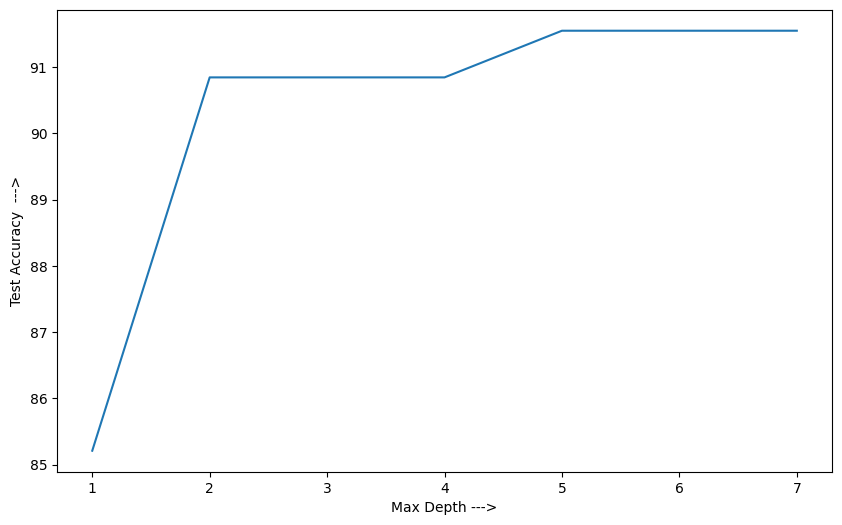

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(depths, accuracies)
plt.xlabel('Max Depth --->')
plt.ylabel('Test Accuracy  --->')
plt.show()

The decision tree is a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.
As observed, max test accuracy occurs when depth is 5.
The decision tree iterates itself till it reaches 100% accuracy on the training data. The highest accuracy on the test data happens when the accuracy on the training data is 100%.
It predicts if the tumor is B or M type based on the features  the algorithm has learned in the training section.
The prediction function is applied to both training and test data.